# System Data

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

In [2]:
np.set_printoptions(linewidth=200, precision=4)

In [3]:
file = 'case39.xlsx'

bus = pd.read_excel(file, sheet_name='bus')
gen = pd.read_excel(file, sheet_name='gen')
branch = pd.read_excel(file, sheet_name='branch')

In [4]:
def make_ybus(bus, branch, baseMVA=100, dense=False):

    nbus = len(bus)
    nline = len(branch)

    stat = branch['status'].values
    ys = stat / (branch['r'].values + 1j*branch['x'].values)
    bc = stat * branch['b'].values

    tap = np.array([1 if ratio == 0 else ratio for ratio in branch['ratio']])
    tap = tap * np.exp(1j*np.pi/180 * branch['angle'].values)

    ytt = ys + 1j*bc*0.5
    yff = ytt / (tap * np.conj(tap))
    yft = - ys / np.conj(tap)
    ytf = - ys / tap

    ysh = (bus['Gs'].values + 1j*bus['Bs'].values) / baseMVA


    idx_line = np.arange(nline)
    idx_bus = np.arange(nbus)
    idx_from = branch['fbus'].values - 1
    idx_to = branch['tbus'].values - 1
    
    cf = coo_matrix((np.ones(nline), (idx_line, idx_from)), shape=(nline, nbus))
    ct = coo_matrix((np.ones(nline), (idx_line, idx_to)), shape=(nline, nbus))
    yff_mat = coo_matrix((yff, (idx_line, idx_line)), shape=(nline, nline))
    yft_mat = coo_matrix((yft, (idx_line, idx_line)), shape=(nline, nline))
    ytf_mat = coo_matrix((ytf, (idx_line, idx_line)), shape=(nline, nline))
    ytt_mat = coo_matrix((ytt, (idx_line, idx_line)), shape=(nline, nline))

    yfrom = yff_mat@cf + yft_mat@ct
    yto = ytf_mat@cf + ytt_mat@ct

    ybus = cf.T@yfrom + ct.T@yto + coo_matrix((ysh, (idx_bus, idx_bus)), shape=(nbus, nbus))

    if not dense:
        return ybus
    else:
        return ybus.toarray()

In [5]:
Ybus = make_ybus(bus, branch, dense=True)

In [6]:
baseMVA = 100

nbus = len(bus)
nline = len(branch)
ngen = len(gen)

Pd = bus['Pd'].values / baseMVA
Qd = bus['Qd'].values / baseMVA
Vmin = bus['Vmin'].values
Vmax = bus['Vmax'].values

gcost = gen['Cost'].values
Qmin = gen['Qmin'].values / baseMVA
Qmax = gen['Qmax'].values / baseMVA
Pmin = gen['Pmin'].values / baseMVA
Pmax = gen['Pmax'].values / baseMVA

Ibg = coo_matrix((np.ones(ngen), (gen['bus'].values-1, np.arange(ngen))), 
                 shape=(nbus, ngen)).toarray()
delta = {i: list(branch.loc[branch['tbus'] == i+1, 'fbus'] - 1) + list(branch.loc[branch['fbus'] == i+1, 'tbus'] - 1) 
         for i in range(nbus)}
idx_from = branch['fbus'].values - 1
idx_to = branch['tbus'].values - 1
G = Ybus.real
B = Ybus.imag
Amax = branch['angmax'].values * np.pi / 180
Amin = branch['angmin'].values * np.pi / 180
Tmax = branch['rateA'].values / baseMVA

# Modeling and Solution

In [7]:
import rsome as rso
from rsome import ro
from rsome import msk_solver as msk
from rsome import grb_solver as grb
import matplotlib.pyplot as plt

## McCormick Relaxation

In [8]:
def mc_envolope(w, x, y, xb, yb):
    
    return (w >= yb[0]*x + xb[0]*y - xb[0]*yb[0],
            w >= yb[1]*x + xb[1]*y - xb[1]*yb[1],
            w <= yb[0]*x + xb[1]*y - xb[1]*yb[0],
            w <= yb[1]*x + xb[0]*y - xb[0]*yb[1])

In [9]:
model = ro.Model()

p = model.dvar(ngen)
q = model.dvar(ngen)

c = model.dvar((nbus, nbus))
s = model.dvar((nbus, nbus))
C = model.dvar((nbus, nbus))
S = model.dvar((nbus, nbus))
D = model.dvar((nbus, nbus))
v = model.dvar((nline, 2))


cost = gen['Cost'].values
model.min(cost@(p*baseMVA))                                                       # Total cost of real power

pg = Ibg@p                                                                        # Real power at each bus
qg = Ibg@q                                                                        # Reactive power at each bus
for i in range(nbus):
    j = delta[i]                                                                  # Set of neighboring buses of bus i
    cii = c[i, i]
    cij = c[i, j]
    sij = s[i, j]
    
    model.st(pg[i] - Pd[i] == G[i, i]*cii + (G[i, j]*cij - B[i, j]*sij).sum())    # Real power balance
    model.st(qg[i] - Qd[i] == -B[i, i]*cii + (-B[i, j]*cij - G[i, j]*sij).sum())  # Reactive power balance
    model.st(cii >= Vmin[i]**2, cii <= Vmax[i]**2)                                # Ranges of volatage magnitudes

for k, (i, j) in enumerate(zip(idx_from, idx_to)):
    cij, cji = c[i, j], c[j, i]
    sij, sji = s[i, j], s[j, i]
    cii, cjj = c[i, i], c[j, j]
    
    model.st(cij == cji, sij == -sji)                                             # Symmetry of matrices c and s
    
    model.st(C[i, j] + S[i, j] == D[i, j])
    model.st(cij >= - Vmax[i]*Vmax[j], cij <= Vmax[i]*Vmax[j])
    model.st(sij >= - Vmax[i]*Vmax[j], sij <= Vmax[i]*Vmax[j])
    
    model.st(mc_envolope(C[i, j], cij, cij, 
                         [-Vmax[i]*Vmax[j], Vmax[i]*Vmax[j]], 
                         [-Vmax[i]*Vmax[j], Vmax[i]*Vmax[j]]))
    model.st(mc_envolope(S[i, j], sij, sij, 
                         [-Vmax[i]*Vmax[j], Vmax[i]*Vmax[j]], 
                         [-Vmax[i]*Vmax[j], Vmax[i]*Vmax[j]]))
    model.st(mc_envolope(D[i, j], cii, cjj, 
                         [-Vmax[i]*Vmax[i], Vmax[i]*Vmax[i]], 
                         [-Vmax[j]*Vmax[j], Vmax[j]*Vmax[j]]))
    model.st(C[i, j] >= 0, S[i, j] >= 0)
    
    model.st(np.tan(Amin[k])*cij <= sij, sij <= np.tan(Amax[k])*cij)              # Ranges of voltage angles
    
    model.st(v[k, 0] == -G[i, j]*cii + G[i, j]*cij - B[i, j]*sij)
    model.st(v[k, 1] == B[i, j]*cii - B[i, j]*cij - G[i, j]*sij)
    model.st(rso.sumsqr(v[k]) <= Tmax[k]**2)
    
model.st(Pmin <= p, p <= Pmax)                                                    # Ranges of real power
model.st(Qmin <= q, q <= Qmax)                                                    # Ranges of reactive power

model.solve(msk)                                                                  # Solve the SOCP model

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0416s


In [10]:
c()

array([[0.8836, 0.8687, 0.    , ..., 0.    , 0.    , 0.8954],
       [0.8687, 1.0365, 1.0262, ..., 0.    , 0.    , 0.    ],
       [0.    , 1.0262, 1.0246, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.8836, 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.8836, 0.    ],
       [0.8954, 0.    , 0.    , ..., 0.    , 0.    , 0.8836]])

In [11]:
print(model.do_math())
model.get()

Conic program object:
Number of variables:           7948
Continuous/binaries/integers:  7948/0/0
---------------------------------------------
Number of linear constraints:  1183
Inequalities/equalities:       691/492
Number of coefficients:        2837
---------------------------------------------
Number of SOC constraints:     46
---------------------------------------------
Number of ExpCone constraints: 0
---------------------------------------------
Number of PSCone constraints:  0



96490.93929120664

In [12]:
pmc, qmc = p.get(), q.get()

## SDP Relaxation

In [13]:
model = ro.Model()

p = model.dvar(ngen)
q = model.dvar(ngen)

W = model.dvar((2*nbus, 2*nbus))
v = model.dvar((nline, 2))

cost = gen['Cost'].values
model.min(cost@(p*baseMVA))                                                       # Total cost of real power

pg = Ibg@p                                                                        # Real power at each bus
qg = Ibg@q                                                                        # Reactive power at each bus
for i in range(nbus):
    j = delta[i]                                                                  # Set of neighboring buses of bus i
    ip, jp = i + nbus, np.array(j) + nbus
    cii = W[i, i] + W[ip, ip]
    cij = W[i, j] + W[ip, jp]
    sij = W[i, jp] - W[j, ip]
    
    model.st(pg[i] - Pd[i] == G[i, i]*cii + (G[i, j]*cij - B[i, j]*sij).sum())    # Real power balance
    model.st(qg[i] - Qd[i] == -B[i, i]*cii + (-B[i, j]*cij - G[i, j]*sij).sum())  # Reactive power balance
    model.st(cii >= Vmin[i]**2, cii <= Vmax[i]**2)                                # Ranges of volatage magnitudes

    
for k, (i, j) in enumerate(zip(idx_from, idx_to)):
    ip, jp = i + nbus, j + nbus
    cii = W[i, i] + W[ip, ip]
    cij = W[i, j] + W[ip, jp]
    sij = W[i, jp] - W[j, ip]
    
    model.st(np.tan(Amin[k])*cij <= sij, sij <= np.tan(Amax[k])*cij)              # Ranges of voltage angles
    
    model.st(v[k, 0] == -G[i, j]*cii + G[i, j]*cij - B[i, j]*sij)
    model.st(v[k, 1] == B[i, j]*cii - B[i, j]*cij - G[i, j]*sij)
    #v = rso.concat(((-G[i, j]*cii + G[i, j]*cij - B[i, j]*sij)[None, :], 
    #                (B[i, j]*cii - B[i, j]*cij - G[i, j]*sij)[None, :]))
    model.st(rso.sumsqr(v[k]) <= Tmax[k]**2)

model.st(W >> 0)
    
model.st(Pmin <= p, p <= Pmax)                                                    # Ranges of real power
model.st(Qmin <= q, q <= Qmax)                                                    # Ranges of reactive power

model.solve(msk)                                                                  # Solve the SDP model

Being solved by Mosek...
Solution status: Optimal
Running time: 2.6310s


In [14]:
print(model.do_math())
model.get()

Conic program object:
Number of variables:           6427
Continuous/binaries/integers:  6427/0/0
---------------------------------------------
Number of linear constraints:  6655
Inequalities/equalities:       217/6438
Number of coefficients:        14453
---------------------------------------------
Number of SOC constraints:     46
---------------------------------------------
Number of ExpCone constraints: 0
---------------------------------------------
Number of PSCone constraints:  1



138245.37319098628

In [15]:
psdp, qsdp = p.get(), q.get()

## SOCP Relaxation

In [16]:
model = ro.Model()

p = model.dvar(ngen)
q = model.dvar(ngen)

c = model.dvar((nbus, nbus))
s = model.dvar((nbus, nbus))
w = model.dvar((nline, 2))
v = model.dvar((nline, 2))


cost = gen['Cost'].values
model.min(cost@(p*baseMVA))                                                       # Total cost of real power

pg = Ibg@p                                                                        # Real power at each bus
qg = Ibg@q                                                                        # Reactive power at each bus
for i in range(nbus):
    j = delta[i]                                                                  # Set of neighboring buses of bus i
    cii = c[i, i]
    cij = c[i, j]
    sij = s[i, j]
    
    model.st(pg[i] - Pd[i] == G[i, i]*cii + (G[i, j]*cij - B[i, j]*sij).sum())    # Real power balance
    model.st(qg[i] - Qd[i] == -B[i, i]*cii + (-B[i, j]*cij - G[i, j]*sij).sum())  # Reactive power balance
    model.st(cii >= Vmin[i]**2, cii <= Vmax[i]**2)                                # Ranges of volatage magnitudes

for k, (i, j) in enumerate(zip(idx_from, idx_to)):
    cij, cji = c[i, j], c[j, i]
    sij, sji = s[i, j], s[j, i]
    cii, cjj = c[i, i], c[j, j]
    
    model.st(cij == cji, sij == -sji)                                             # Symmetry of matrices c and s
    
    model.st(w[k, 0] == c[i, j], w[k, 1] == s[i, j])         
    model.st(rso.rsocone(w[k], cii, cjj))                                         # Approximation using rotated cone
    
    model.st(np.tan(Amin[k])*cij <= sij, sij <= np.tan(Amax[k])*cij)              # Ranges of voltage angles
    
    model.st(v[k, 0] == -G[i, j]*cii + G[i, j]*cij - B[i, j]*sij)
    model.st(v[k, 1] == B[i, j]*cii - B[i, j]*cij - G[i, j]*sij)
    model.st(rso.sumsqr(v[k]) <= Tmax[k]**2)
    
model.st(Pmin <= p, p <= Pmax)                                                    # Ranges of real power
model.st(Qmin <= q, q <= Qmax)                                                    # Ranges of reactive power

model.solve(msk)                                                                  # Solve the SOCP model

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0263s


In [17]:
print(model.do_math())
model.get()

Conic program object:
Number of variables:           3661
Continuous/binaries/integers:  3661/0/0
---------------------------------------------
Number of linear constraints:  861
Inequalities/equalities:       185/676
Number of coefficients:        2239
---------------------------------------------
Number of SOC constraints:     92
---------------------------------------------
Number of ExpCone constraints: 0
---------------------------------------------
Number of PSCone constraints:  0



137435.49131911524

In [18]:
psoc, qsoc = p.get(), q.get()

In [19]:
# SDP method

model = ro.Model()

p = model.dvar(ngen)
q = model.dvar(ngen)

W = model.dvar((2*nbus, 2*nbus))
v = model.dvar((nline, 2))

cost = gen['Cost'].values
model.min(cost@(p*baseMVA))                                                             # Total cost of real power

pg = Ibg@p                                                                    # Real power at each bus
qg = Ibg@q                                                                    # Reactive power at each bus
for i in range(nbus):
    j = delta[i]                                                              # Set of neighboring buses of bus i
    ip, jp = i + nbus, np.array(j) + nbus
    model.st(pg[i] - Pd[i] == G[i, i]*(W[i, i] + W[ip, ip]) +
             (G[i, j]*(W[i, j] + W[ip, jp]) - B[i, j]*(W[i, jp] - W[j, ip])).sum())     # Real power balance
    model.st(qg[i] - Qd[i] == -B[i, i]*(W[i, i] + W[ip, ip]) + 
             (-B[i, j]*(W[i, j] + W[ip, jp]) - G[i, j]*(W[i, jp] - W[j, ip])).sum())   # Reactive power balance
    model.st(W[i, i] + W[ip, ip] >= Vmin[i]**2, W[i, i] + W[ip, ip] <= Vmax[i]**2)                    # Ranges of volatage magnitudes

    
for k, (i, j) in enumerate(zip(idx_from, idx_to)):
    ip, jp = i + nbus, j + nbus
    cii = W[i, i] + W[ip, ip]
    cij = W[i, j] + W[ip, jp]
    sij = W[i, jp] - W[j, ip]
    model.st(np.tan(Amin[k])*cij <= sij, sij <= np.tan(Amax[k])*cij)
    
    model.st(v[k, 0] == -G[i, j]*cii + G[i, j]*cij - B[i, j]*sij)
    model.st(v[k, 1] == B[i, j]*cii - B[i, j]*cij - G[i, j]*sij)
    model.st(rso.sumsqr(v[k]) <= Tmax[k]**2)

model.st(W >> 0)
    
model.st(Pmin <= p, p <= Pmax)                                                # Ranges of real power
model.st(Qmin <= q, q <= Qmax)                                                # Ranges of reactive power

model.solve(msk)    

Being solved by Mosek...
Solution status: Optimal
Running time: 2.7270s


In [20]:
model.get()

138245.37319098628

In [21]:
model.do_math()

Conic program object:
Number of variables:           6427
Continuous/binaries/integers:  6427/0/0
---------------------------------------------
Number of linear constraints:  6655
Inequalities/equalities:       217/6438
Number of coefficients:        14453
---------------------------------------------
Number of SOC constraints:     46
---------------------------------------------
Number of ExpCone constraints: 0
---------------------------------------------
Number of PSCone constraints:  1

In [22]:
psdp = p.get()

In [23]:
qsdp = q.get()

# Visualization of the Results

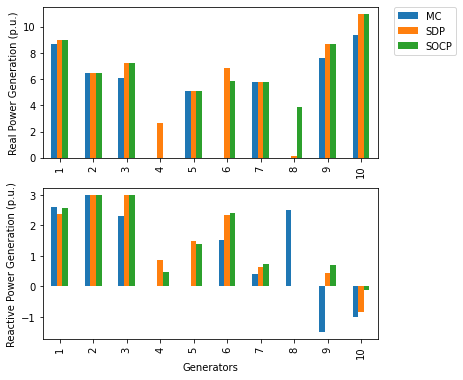

In [24]:
pgs = pd.DataFrame({'Generators': range(1, ngen+1), 
                    'MC': pmc, 'SDP': psdp, 'SOCP': psoc})
qgs = pd.DataFrame({'Generators': range(1, ngen+1), 
                    'MC': qmc, 'SDP': qsdp, 'SOCP': qsoc})

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

pgs.plot('Generators', ['MC', 'SDP', 'SOCP'], kind='bar', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Real Power Generation (p.u.)')
axes[0].legend(bbox_to_anchor=(1.25, 1.03))

qgs.plot('Generators', ['MC', 'SDP', 'SOCP'], kind='bar', ax=axes[1], legend=False)
axes[1].set_ylabel('Reactive Power Generation (p.u.)')

plt.show()